# Gupta (2010)

In which the GMPE of Gupta (2010) is implemented. First coefficient tables are reprocessed for cut & paste in to the .py source code. The author kindly provided test vectors, so they are graphically compared to the implementation.

In [1]:
%matplotlib inline
%load_ext autoreload

## Processing of coefficients

In [2]:
import os
import glob
import warnings
import importlib
import pandas as pd
import numpy as np
import toolbox as tb
import matplotlib.pyplot as plt
from scipy.constants import g
from matplotlib.offsetbox import AnchoredText
from IPython.display import display
from openquake.hazardlib import imt

In [3]:
tables_file = 'Tables/Tables.xlsx'
tables_dir = os.path.split(tables_file)[0]
table_numbers = [4]

coeffs_dfs = [pd.read_excel(tables_file, sheetname='Table%d' % num, skiprows=1) 
               for num in table_numbers]
coeffs_txts = [os.path.join(tables_dir, 'Table%d.txt' % num) 
               for num in table_numbers]

for coeffs_df, coeffs_txt in zip(coeffs_dfs, coeffs_txts):
    with open(coeffs_txt, 'w') as f:
        f.write(coeffs_df.to_string(index=False))

coeffs_df = coeffs_dfs[0]
coeffs_df.set_index(keys='IMT', inplace=True)

In [4]:
coeffs_df

,c1,c2,c3,c4,c5,c6,c7,c8,sigma
IMT,,,,,,,,,
0.02,0.4598,0.69090,0.01130,-0.00202,0.19,0.24,0.29,-0.3312,0.347
0.04,0.7382,0.63273,0.01275,-0.00234,0.15,0.20,0.20,-0.3090,0.343
0.10,1.0081,0.66675,0.01080,-0.00219,0.15,0.23,0.20,-0.3005,0.341
0.20,1.2227,0.69186,0.00572,-0.00192,0.15,0.27,0.25,-0.4001,0.340
0.40,0.8798,0.77270,0.00173,-0.00178,0.13,0.37,0.38,-0.4408,0.341
1.00,-0.3339,0.87890,0.00130,-0.00173,0.10,0.30,0.55,-0.3380,0.344
2.00,-2.0677,0.99640,0.00364,-0.00118,0.10,0.25,0.40,-0.2674,0.347
3.00,-3.4227,1.11690,0.00615,-0.00045,0.10,0.25,0.36,-0.3942,0.351


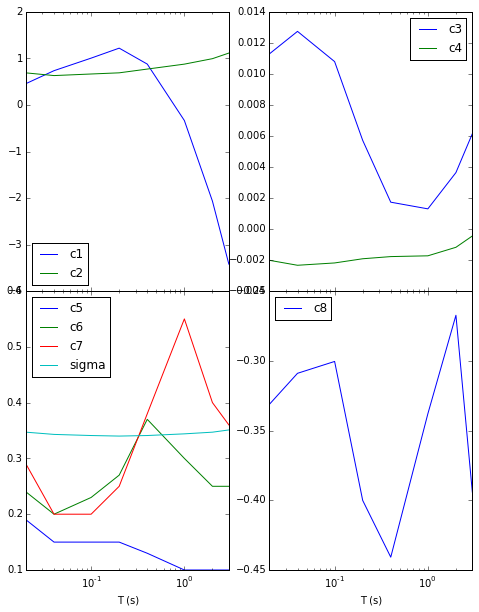

In [5]:
sa_df = coeffs_df.copy()
sa_df['T (s)'] = sa_df.index.values
fig, axes = plt.subplots(2, 2, figsize=(8,10), sharex=True)
fig.subplots_adjust(hspace=0)
sa_df.plot(x='T (s)', y=['c1', 'c2',], ax=axes[0,0], logx=True)
sa_df.plot(x='T (s)', y=['c3', 'c4'], ax=axes[0,1], logx=True)
sa_df.plot(x='T (s)', y=['c5', 'c6', 'c7', 'sigma'], ax=axes[1,0], logx=True)
sa_df.plot(x='T (s)', y=['c8'], ax=axes[1,1], logx=True)
plt.savefig('Figure_5_and_rest_of_coefficients.pdf', dpi=300, bbox_inches='tight')

## Testing of GMPE

In [6]:
%autoreload 2
import gmpe_tools as gt

%autoreload 2
from openquake.hazardlib.gsim.gupta_2010 import Gupta2010SSlab

In [7]:
gmpe_group = 'GUPT10'
gmpes = [Gupta2010SSlab()]
gmpe_class_names = [gmpe.__class__.__name__ for gmpe in gmpes]
gmpes_short = ['']
gmpes_long = ['Gupta (2010)']

In [8]:
for gmpe in gmpes:
    gt.print_gmpe_summary(gmpe)

Gupta2010SSlab
Supported tectonic region: Subduction IntraSlab
Supported intensity measure types: SA, PGA
Supported component: Median horizontal
Supported standard deviations: Total
Required site parameters: vs30
Required rupture parameters: hypo_depth, mag
Required distance parameters: rrup



In [43]:
RENAME_COLS = {
    'Mw': 'rup_mag', 
    'Rrup': 'dist_rrup', 
    'H': 'rup_hypo_depth', 
    'Result': 'result_type', 
    'Damping': 'damping', 
    0.02: 'PGA',
}

REPLACE_VALS = {
    'Mean': 'MEAN'
}
    
CLASS_VS30_TYP = {
    'A': 2000,
    'B': 1000.,
    'C': 500.,
    'D': 250.,
    'E': 100.,
}

In [44]:
df_gupta = pd.read_excel('GUPTA.xls')
df_gupta.rename(columns=RENAME_COLS, inplace=True)
df_gupta['site_vs30'] = df_gupta['NEHRP'].replace(CLASS_VS30_TYP)
df_gupta.replace(REPLACE_VALS, inplace=True)
df_gupta['gmpe'] = gmpe_class_names[0]
df_gupta.drop([0.01, 'NEHRP'], axis=1, inplace=True)
df_gupta = gt.df_massage(df_gupta)

means_files = gt.write_test_data(df_gupta, gmpe_group, gmpes_short, gmpe_class_names)

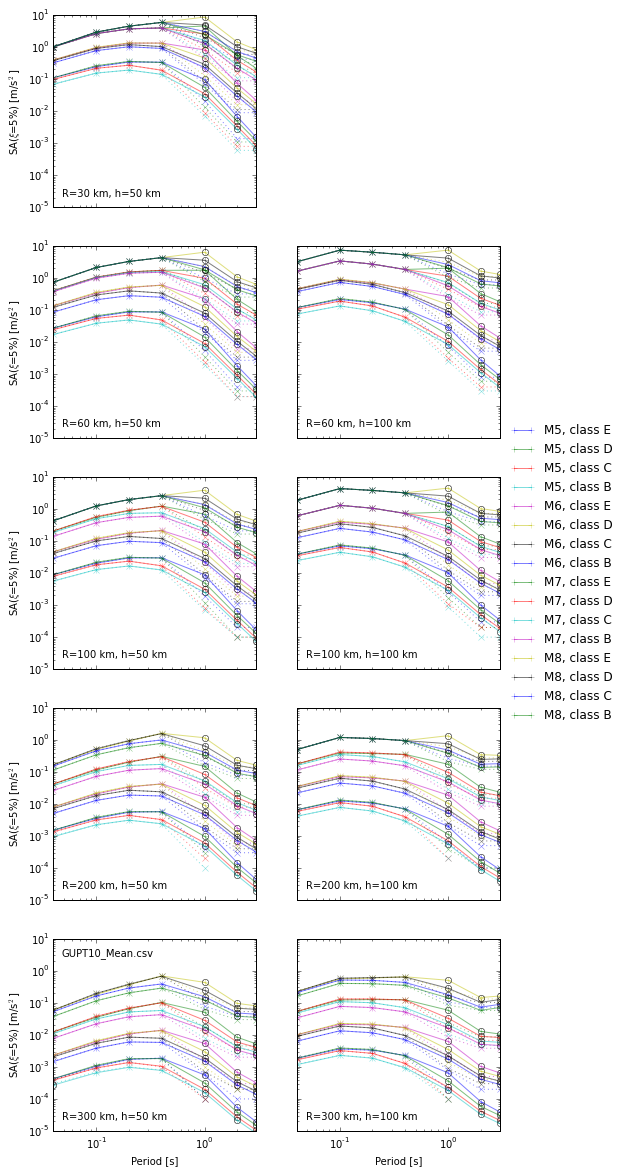

In [37]:
# run through unittests
threshhold = 0.10

means_file = means_files[0]
gmpe = gmpes[0]
gmpe_name = gmpe.__class__.__name__

df_ref = gt.df_massage(pd.read_csv(means_file))

mags = sorted(list(set(df_ref['rup_mag'])))
ruptures = sorted(list(set(df_ref['rup_hypo_depth'])))
distances = sorted(list(set(df_ref['dist_rrup'])))
vs30s = np.sort(np.array(list(set(df_ref['site_vs30']))))
sa_cols = np.array([tb.is_numeric(item) for item in df_ref.columns])
imt_cols = np.array([gt.is_imt(item) for item in df_ref.columns])
im_types = [gt.get_imt(item) for item in df_ref.columns[imt_cols]]
damping = next(iter([im_type.damping for im_type in im_types
                     if isinstance(im_type, imt.SA)]), 5)

df_new = gt.compute_gmpe(gmpe, mags, ruptures, distances, vs30s, im_types)[0]
df_new = df_new[df_ref.columns]

if sum(sa_cols) > 2:  # x-axis will be spectral acceleration period
    fig, axes = plt.subplots(len(distances), len(ruptures), sharex=True, sharey=True, 
                             figsize=(4*len(ruptures), 4*len(distances)))
    for dist, ax_row in zip(distances, axes):
        for rupt, ax in zip(ruptures, ax_row):
            if dist < rupt/2:
                ax.axis('off')
                continue
                
            ax.add_artist(AnchoredText('R=%g km, h=%g km' % (dist, rupt), 
                                       loc=tb.LOC_CODE['lower left'], frameon=False))
            for mag in mags:
                for vs30 in vs30s:
                    nehrp_class = [key for key in CLASS_VS30_TYP.keys() if CLASS_VS30_TYP[key] == vs30][0]
                    trace_label = 'M%g, class %s' % (mag, nehrp_class)

                    df_trace = df_ref[
                        (df_ref['rup_mag'] == mag) & 
                        (df_ref['rup_hypo_depth'] == rupt) & 
                        (df_ref['dist_rrup'] == dist) & 
                        (df_ref['site_vs30'] == vs30)]
                    if df_trace.size == 0:
                        continue
                    ref = df_trace[df_ref.columns[sa_cols]]

                    df_trace = df_new[
                        (df_new['rup_mag'] == mag) & 
                        (df_new['rup_hypo_depth'] == rupt) & 
                        (df_new['dist_rrup'] == dist) & 
                        (df_new['site_vs30'] == vs30)]
                    new = df_trace[df_ref.columns[sa_cols]]

                    h = ax.loglog(new.columns.values, new.values.reshape((-1,)), 
                                  label=trace_label, alpha=0.5, marker='+')

                    ax.loglog(ref.columns.values, ref.values.reshape((-1,)), 
                              color=h[0].get_color(), alpha=0.5, marker='x', linestyle=':')

                    # circle points in error
                    error = (np.abs(new.values/ref.values - 1) > threshhold).reshape((-1,))
                    ax.loglog(new.iloc[0, error].index.values, new.iloc[0, error].values, 
                              linestyle='none', marker='o', color='black', markerfacecolor='none')

        ax_row[0].set_ylabel('SA($\\xi$=%g%%) [m/s$^2$]' % damping)
        
    for ax in axes[-1,:]:
        ax.set_xlabel('Period [s]')
        ax.autoscale(True, 'x', True)
    axes[-1, 0].add_artist(AnchoredText(os.path.split(means_file)[1], 
                                      loc=tb.LOC_CODE['upper left'], frameon=False))
    axes[axes.shape[0]/2, -1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False);

else:  # x-axis will be distance (could be magnitude)
    fig, ax = plt.subplots(1, 1)

    ax.add_artist(AnchoredText(gmpe_name, 
                               loc=tb.LOC_CODE['upper left'], frameon=False))
    ax.add_artist(AnchoredText(os.path.split(means_file)[1], 
                               loc=tb.LOC_CODE['upper right'], frameon=False))
    for vs30 in vs30s:
        for mag in mags:
            for im_type in im_types:
                trace_label = '%s, M=%g, %g m/s' % (str(im_type), mag, vs30)

                df_trace_ref = df_ref[
                    (df_ref['rup_mag'] == mag) & 
                    (df_ref['site_vs30'] == vs30)]
                if df_trace_ref.size == 0:
                    continue

                h = ax.loglog(df_trace_ref['dist_rrup'], df_trace_ref[str(im_type)], 
                              label=trace_label, alpha=0.5)

                df_trace_new = df_new[
                    (df_new['rup_mag'] == mag) & 
                    (df_new['site_vs30'] == vs30)]

                ax.loglog(df_trace_new['dist_rrup'], df_trace_new[str(im_type)], 
                          linestyle='none', marker='x', 
                          color=h[0].get_color(), alpha=0.5)

                # circle points in error
                error = (np.abs(df_trace_new[str(im_type)]/df_trace_ref[str(im_type)] - 1) > threshhold).reshape((-1,))
                ax.loglog(df_trace_new.loc[error, 'dist_rrup'], df_trace_new.loc[error, str(im_type)], 
                          linestyle='none', marker='o', color='black', markerfacecolor='none')

    ax.set_ylabel('Ground Motion')
    ax.set_xlabel('Distance [km]')

    ax.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False);
                
plt.savefig('Unit_Test_Summary.pdf', dpi=300, bbox_inches='tight')
plt.savefig('Unit_Test_Summary.png', dpi=300, bbox_inches='tight')